In [1]:
%matplotlib nbagg
import numpy as np
import json
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft, fftfreq, fftshift
from IPython.display import clear_output, display

from alvra_tools.load_data import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm, threshold
import glob

In [2]:
scan_name ="timescan_2840eV_6"

DIR_json = "/sf/alvra/data/p18442/res/scan_info/"
DIR = "/sf/alvra/data/p18442/raw/scan_data/" + scan_name + "/"             #use this for a scan

#######################################################################

files_scan = glob.glob(DIR_json + scan_name + '.*')
print (files_scan)
scan_range = '.'+files_scan[-1].split('.')[-2]
print (scan_range)

!ls -lah -rt $DIR | grep BSREAD.h5
!hostname

['/sf/alvra/data/p18442/res/scan_info/timescan_2840eV_6.run001674-001716.json']
.run001674-001716
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:38 run_001674.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:39 run_001675.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:40 run_001676.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:42 run_001677.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:44 run_001678.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:46 run_001679.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:48 run_001680.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:50 run_001681.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:51 run_001682.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:53 run_001683.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:55 run_001684.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:57 run_001685.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:59 run_001686.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2

# Load one file and check signal levels

### First plot pump/unpump to see if channels are all right

Found 9999 shots in the file
Load 9998 shots
Pump/umpump arrays have 2500 shots each
Delay = 152.87142776012672 mm
Median value Izero (all) = 0.2951323613524437
Median value fluo (all) = 0.27081721844059403


<IPython.core.display.Javascript object>


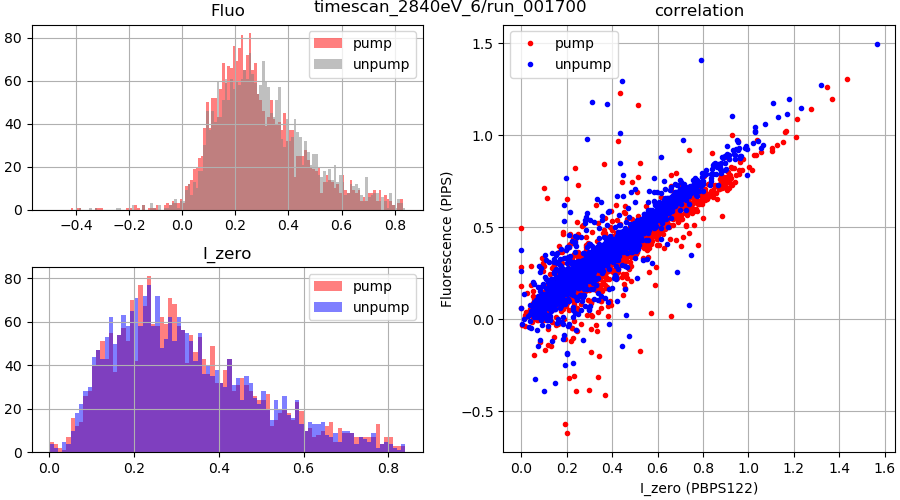

In [3]:
f ="run_001700.BSREAD.h5"
fn = DIR + f

(DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Delay_shot, \
 DataTrans_pump_shot, DataTrans_unpump_shot, pids_shot) = load_PumpProbe_events(fn, channel_delay)

IzeroFEL_pump_raw = IzeroFEL_pump_shot.copy()
IzeroFEL_unpump_raw = IzeroFEL_unpump_shot.copy()
DataFluo_pump_shot_raw = DataFluo_pump_shot.copy()
DataFluo_unpump_shot_raw = DataFluo_unpump_shot.copy()

print ("Delay = {} mm".format(Delay_shot.mean()))
print ("Median value Izero (all) = {}".format(np.median(np.concatenate((IzeroFEL_pump_raw, IzeroFEL_unpump_raw), axis=0))))
print ("Median value fluo (all) = {}".format(np.median(np.concatenate((DataFluo_pump_shot_raw, DataFluo_unpump_shot_raw), axis=0))))

fig = plt.figure(constrained_layout=True, figsize=(9,5))
plt.suptitle(scan_name +"/"+ f.split('.')[0], y = 1)
gs = fig.add_gridspec(2, 2)

f_ax1 = fig.add_subplot(gs[0, :-1])
f_ax1.set_title('Fluo')
plt.hist(DataFluo_pump_shot, bins =np.arange(-0.5,0.85,0.01), facecolor='red', label="pump", alpha=0.5)
plt.hist(DataFluo_unpump_shot, bins =np.arange(-0.5,0.85,0.01), facecolor='grey', label="unpump", alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax2 = fig.add_subplot(gs[1, :-1])
f_ax2.set_title('I_zero')
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,0.85,0.01), facecolor='red', label='pump', alpha=0.5)
plt.hist(IzeroFEL_unpump_shot, bins =np.arange(0,0.85,0.01), facecolor='blue', label ='unpump', alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax3 = fig.add_subplot(gs[0:, 1])
f_ax3.set_title('correlation')
plt.plot(IzeroFEL_pump_shot, DataFluo_pump_shot, color = 'red',  linestyle='None', label='pump',marker='.')
plt.plot(IzeroFEL_unpump_shot, DataFluo_unpump_shot, color = 'blue',  linestyle='None', label='unpump',marker='.')
plt.grid()
plt.legend(loc="best")
plt.xlabel("I_zero (PBPS122)")
plt.ylabel ("Fluorescence (PIPS)")

plt.show()

### Then filter the same data

In [4]:
min_I0 = 0.01
min_fluo = 0.001
quantile_corr = 0.5
########################################################################################################

ffn = DIR + f

(DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Delay_shot, \
 DataTrans_pump_shot, DataTrans_unpump_shot, pids_shot) = load_PumpProbe_events(ffn, channel_delay)

IzeroFEL_pump_raw = IzeroFEL_pump_shot.copy()
IzeroFEL_unpump_raw = IzeroFEL_unpump_shot.copy()
DataFluo_pump_shot_raw = DataFluo_pump_shot.copy()
DataFluo_unpump_shot_raw = DataFluo_unpump_shot.copy()

threshold_FEL_pump = IzeroFEL_pump_shot > min_I0
threshold_FEL_unpump = IzeroFEL_unpump_shot > min_I0
threshold_fluo_pump = DataFluo_pump_shot > min_fluo
threshold_fluo_unpump = DataFluo_unpump_shot > min_fluo

thresholds_filter = threshold_FEL_pump & threshold_FEL_unpump & \
                   threshold_fluo_pump & threshold_fluo_unpump

DataFluo_pump_shot = DataFluo_pump_shot[thresholds_filter]
DataFluo_unpump_shot = DataFluo_unpump_shot[thresholds_filter]
IzeroFEL_pump_shot = IzeroFEL_pump_shot[thresholds_filter]
IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[thresholds_filter]

DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
DataFluo_pump_shot_norm_raw = DataFluo_pump_shot_norm.copy()

med = np.median(DataFluo_unpump_shot_norm)
qnt_low = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 - quantile_corr/2)
qnt_high = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 + quantile_corr/2)

condition_corr_unpump_low = DataFluo_unpump_shot_norm > qnt_low
condition_corr_unpump_high = DataFluo_unpump_shot_norm < qnt_high

med = np.median(DataFluo_pump_shot_norm)
qnt_low = np.nanquantile(DataFluo_pump_shot_norm, 0.5 - quantile_corr/2)
qnt_high = np.nanquantile(DataFluo_pump_shot_norm, 0.5 + quantile_corr/2)

condition_corr_pump_low = DataFluo_pump_shot_norm > qnt_low
condition_corr_pump_high = DataFluo_pump_shot_norm < qnt_high

correlation_filter = condition_corr_unpump_low & condition_corr_unpump_high & \
                    condition_corr_pump_low & condition_corr_pump_high

DataFluo_pump_shot_norm = DataFluo_pump_shot_norm[correlation_filter]
DataFluo_unpump_shot_norm = DataFluo_unpump_shot_norm[correlation_filter]

print ("Original size (pump/umpump):", len(DataFluo_pump_shot_raw), len(DataFluo_unpump_shot_raw))
print ("Filtered size conditions (pump/unpump):", len(DataFluo_pump_shot), len(DataFluo_unpump_shot))
print ("Filtered size correlation (pump/unpump):", len(DataFluo_pump_shot_norm), len(DataFluo_unpump_shot_norm))
print ("Delay = {} mm".format(Delay_shot.mean()))
print ("Median value Izero (filter) = {}".format(np.median(IzeroFEL_pump_shot)))
print ("Median value fluo (filter) = {}".format(np.median(DataFluo_pump_shot_raw)))


Found 9999 shots in the file
Load 9998 shots
Pump/umpump arrays have 2500 shots each
Original size (pump/umpump): 2499 2499
Filtered size conditions (pump/unpump): 2421 2421
Filtered size correlation (pump/unpump): 630 630
Delay = 152.87142776012672 mm
Median value Izero (filter) = 0.30068622529506683
Median value fluo (filter) = 0.2559439781868812


<IPython.core.display.Javascript object>


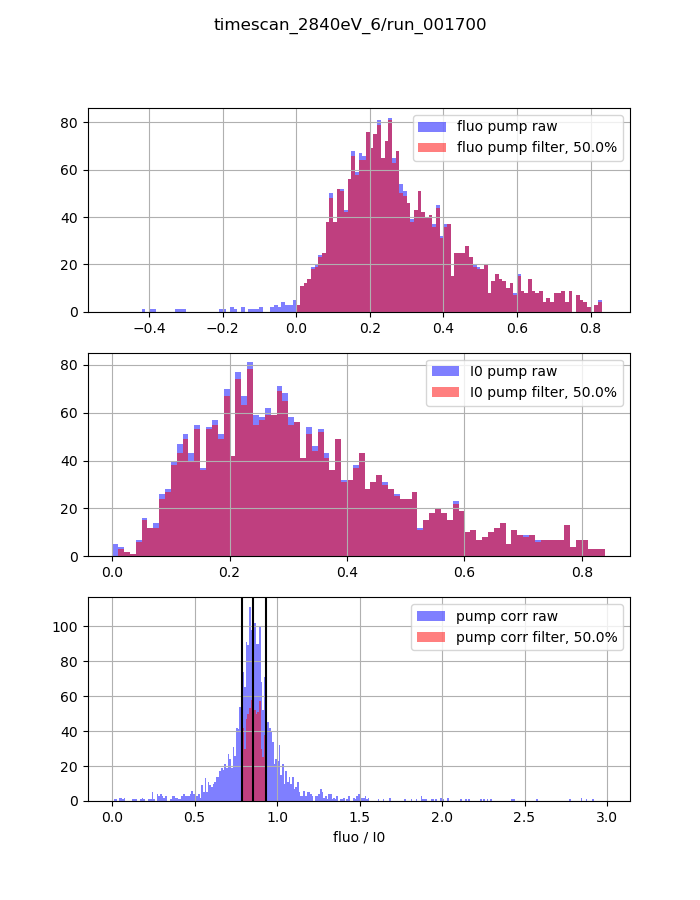

In [5]:
plt.figure(figsize = (7,9))
plt.suptitle(scan_name +"/"+ f.split('.')[0])

plt.subplot(311)
plt.hist(DataFluo_pump_shot_raw, bins =np.arange(-0.5,0.85,0.01), facecolor='blue', label="fluo pump raw", alpha=0.5)
plt.hist(DataFluo_pump_shot, bins =np.arange(-0.5,0.85,0.01), facecolor='red', label="fluo pump filter, {}%".format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")

plt.subplot(312)
plt.hist(IzeroFEL_pump_raw, bins =np.arange(0,0.85,0.01), facecolor='blue', label='I0 pump raw', alpha=0.5)
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,0.85,0.01), facecolor='red', label ='I0 pump filter, {}%'.format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")

plt.subplot(313)
x_axis = np.arange(0,3,0.01)
plt.hist(DataFluo_pump_shot_norm_raw, bins =x_axis, facecolor='blue', label='pump corr raw', alpha=0.5)
plt.hist(DataFluo_pump_shot_norm, bins =x_axis, facecolor='red', label='pump corr filter, {}%'.format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")
plt.axvline(med, color = 'k') 
plt.axvline(qnt_low, color = 'k')
plt.axvline(qnt_high, color = 'k') 
plt.xlabel('fluo / I0')

plt.show()

# Now load the full scan

### First, without any filtering of the data, check data distributions with quantiles 

In [6]:
quantiles = [0.5, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9]

Timezero = 155.35 # position of Timezero on PP delay (in mm!)

##################################################################
json_file = DIR_json + scan_name + scan_range + ".json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 35

print ("Processing",numFiles,"files")

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

Pump_probe = []
err_Pump_probe = []

Delay_mm = []

for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][0])    
    testdata = check_files_and_data(filename)
    if testdata: #and i!=0:
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        (DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Delay_shot, \
         DataTrans_pump_shot, DataTrans_unpump_shot, pids_shot) = load_PumpProbe_events(filename, channel_delay)
        
        print ("Loaded {} shots".format(len(DataFluo_pump_shot)))
    
        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
        
        df_pump = pd.DataFrame(DataFluo_pump_shot_norm)
        df_unpump = pd.DataFrame(DataFluo_unpump_shot_norm)
        df_pump_probe = pd.DataFrame(Pump_probe_shot)
              
        DataFluo_pump.append(np.nanquantile(df_pump, quantiles))
        DataFluo_unpump.append(np.nanquantile(df_unpump, quantiles))
        Pump_probe.append(np.nanquantile(df_pump_probe, quantiles))
        
        Delay_shot = [x for x in Delay_shot if (np.abs(x) > 0)]
        Delay_mm.append(np.mean(Delay_shot))
    
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
Pump_probe = np.asarray(Pump_probe)

Delay_mm = np.asarray(Delay_mm)
Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

print ("Job done!")


step 43 of 43 : Processing /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001716.BSREAD.h5
Found 9999 shots in the file
Load 9998 shots
Pump/umpump arrays have 2499 shots each
Loaded 2499 shots
Job done!


<IPython.core.display.Javascript object>


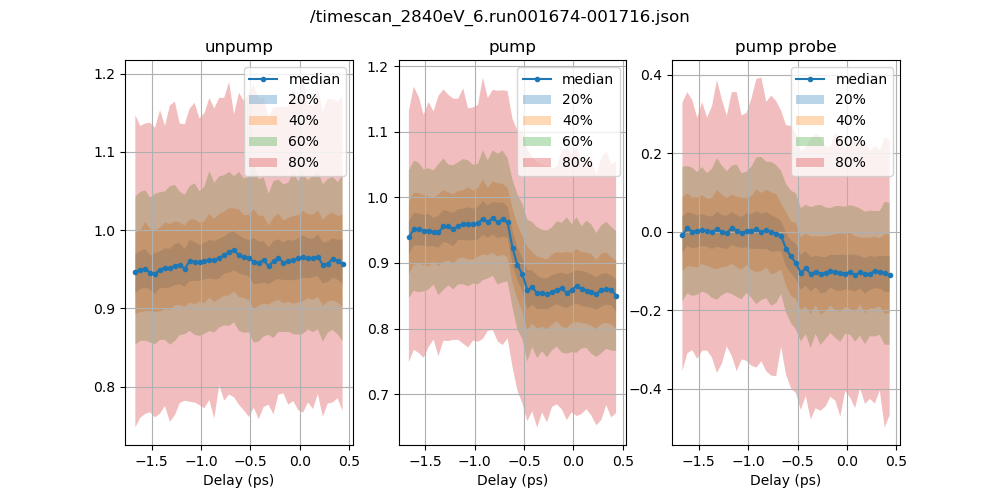

In [7]:
plt.figure(figsize = (10,5))
plt.suptitle(json_file.split('scan_info')[1], fontsize=12)

plt.subplot(1,3,1)
plt.plot(Delay_ps, DataFluo_unpump[:,0],label='median',marker='.' )
plt.fill_between(Delay_ps,np.array(DataFluo_unpump[:,4]),np.array(DataFluo_unpump[:,5]), label='20%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(DataFluo_unpump[:,3]),np.array(DataFluo_unpump[:,6]), label='40%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(DataFluo_unpump[:,2]),np.array(DataFluo_unpump[:,7]), label='60%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(DataFluo_unpump[:,1]),np.array(DataFluo_unpump[:,8]), label='80%', alpha = 0.3)
plt.grid()
plt.gca().set_title('unpump')
plt.legend(loc="best")
#plt.ylabel("XAS ground state")
plt.xlabel("Delay (ps)")

plt.subplot(1,3,2)
plt.plot(Delay_ps, DataFluo_pump[:,0],label='median',marker='.' )
plt.fill_between(Delay_ps,np.array(DataFluo_pump[:,4]),np.array(DataFluo_pump[:,5]), label='20%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(DataFluo_pump[:,3]),np.array(DataFluo_pump[:,6]), label='40%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(DataFluo_pump[:,2]),np.array(DataFluo_pump[:,7]), label='60%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(DataFluo_pump[:,1]),np.array(DataFluo_pump[:,8]), label='80%', alpha = 0.3)
plt.grid()
plt.gca().set_title('pump')
plt.legend(loc="best")
#plt.ylabel("XAS ground state")
plt.xlabel("Delay (ps)")

plt.subplot(1,3,3)
plt.plot(Delay_ps, Pump_probe[:,0],label='median',marker='.' )
plt.fill_between(Delay_ps,np.array(Pump_probe[:,4]),np.array(Pump_probe[:,5]), label='20%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(Pump_probe[:,3]),np.array(Pump_probe[:,6]), label='40%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(Pump_probe[:,2]),np.array(Pump_probe[:,7]), label='60%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(Pump_probe[:,1]),np.array(Pump_probe[:,8]), label='80%', alpha = 0.3)
plt.grid()
plt.gca().set_title('pump probe')
plt.legend(loc="best")
#plt.ylabel("Delta XAS")
plt.xlabel("Delay (ps)")

plt.show()

In [9]:
min_I0 = 0.01
min_fluo = 0.001
quantile_corr = 0.2

Timezero = 155.35 # position of Timezero on PP delay (in mm!)

########################################################################
json_file = DIR_json + scan_name + scan_range + ".json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 35

print ("Processing",numFiles,"files")

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

Pump_probe = []
err_Pump_probe = []

Delay_mm = []

for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][0])    
    testdata = check_files_and_data(filename)
    if testdata: #and i!=0:
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        (DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Delay_shot, \
         DataTrans_pump_shot, DataTrans_unpump_shot, pids_shot) = load_PumpProbe_events(filename, channel_delay)
        
        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
        
        df_pump = pd.DataFrame(DataFluo_pump_shot_norm)
        df_unpump = pd.DataFrame(DataFluo_unpump_shot_norm)
        df_pump_probe = pd.DataFrame(Pump_probe_shot)
        
        DataFluo_pump.append(np.nanquantile(df_pump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        DataFluo_unpump.append(np.nanquantile(df_unpump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        
        #Delay_shot = [x for x in Delay_shot if (np.abs(x) > 0)]
        #Delay_mm.append(np.mean(Delay_shot))
        Delays_stage_mm.append(data['scan_readbacks'][i]) ## Delay from the json file
    
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
Pump_probe = np.asarray(Pump_probe)
                  
Delay_mm = np.asarray(Delay_mm)
Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

print ("Job done!")


step 43 of 43 : Processing /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001716.BSREAD.h5
Found 9999 shots in the file
Load 9998 shots
Pump/umpump arrays have 2499 shots each
Job done!


# Plot delay scans

<IPython.core.display.Javascript object>


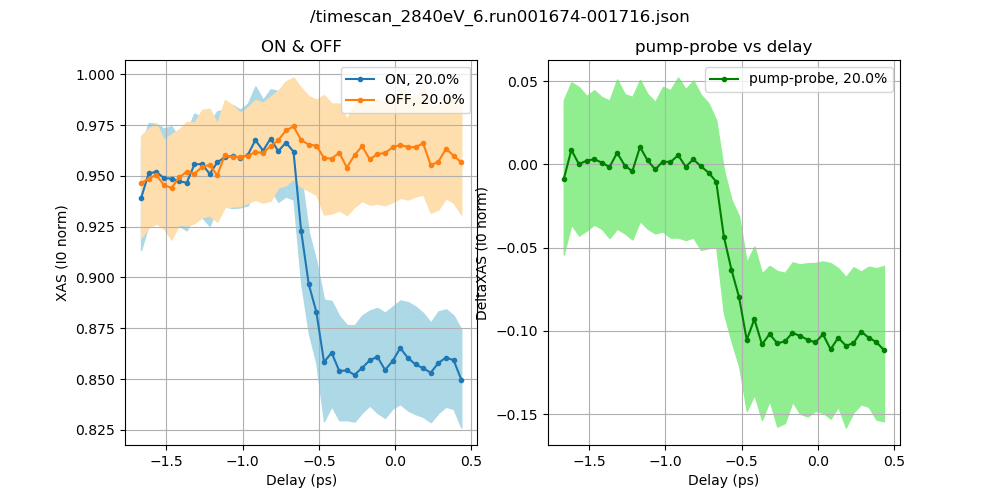

t0 = 155.35 mm


In [10]:
plt.figure(figsize = (10,5))
plt.suptitle(json_file.split('scan_info')[1], fontsize=12)

Pump_probe_relative = (DataFluo_pump - DataFluo_unpump) / DataFluo_unpump
pump = DataFluo_pump[:,0]
err_low_pump = DataFluo_pump[:,1]
err_high_pump = DataFluo_pump[:,2]
unpump = DataFluo_unpump[:,0]
err_low_unpump = DataFluo_unpump[:,1]
err_high_unpump = DataFluo_unpump[:,2]
pump_probe = Pump_probe[:,0]
err_low_pump_probe = Pump_probe[:,1]
err_high_pump_probe = Pump_probe[:,2]

plt.subplot(1,2,1)
plt.plot(Delay_ps, pump, label='ON, {}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Delay_ps, err_low_pump, err_high_pump, color='lightblue')

plt.plot(Delay_ps, unpump, label='OFF, {}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Delay_ps, err_low_unpump, err_high_unpump, color='navajowhite')

plt.xlabel("Delay (ps)")
plt.ylabel ("XAS (I0 norm)")
plt.gca().set_title('ON & OFF')
plt.legend(loc="best")
plt.grid()

plt.subplot(1,2,2)
plt.plot(Delay_ps, pump_probe, label='pump-probe, {}%'.format(quantile_corr*100),color='green', marker='.')
plt.fill_between(Delay_ps,err_low_pump_probe, err_high_pump_probe, color='lightgreen')
plt.xlabel("Delay (ps)")
plt.ylabel ("DeltaXAS (I0 norm)")
plt.gca().set_title('pump-probe vs delay')
plt.legend(loc="best")
plt.grid()

plt.show()
print ('t0 = {} mm'.format(Timezero))

In [11]:
import photodiag

#DIRcalib = '/sf/photo/src/PALM/calib/'
#DIRcalib = '/sf/photo/src/PALM/calib/Alvra'
DIRcalib = '/sf/alvra/data/p18442/res/PhotoDiag/scan_info/'

CalibrationFn = DIRcalib + '2020-01-31_17:42:38.palm_etof'

energyFrom =  1200
energyTo =    1500
energySteps = 2000
palm = photodiag.PalmSetup({'0': 'SAROP11-PALMK118:CH1_BUFFER', '1': 'SAROP11-PALMK118:CH2_BUFFER'},
                 noise_range=[0, 250],
                 energy_range=np.linspace(energyFrom, energyTo, energySteps))

palm.load_etof_calib(CalibrationFn)

In [32]:
quantile_corr = 0.2
ev2fsCalib= -18.913301646032846    # This is from THz scan_010
Timezero = 155.35                 # position of Timezero on PP delay (in mm!)

########################################################################
json_file = DIR_json + scan_name + scan_range + ".json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 35

print ("Processing",numFiles,"files")

DataFluo_pump = []
DataFluo_unpump = []
Pump_probe = []
Pump_probe_all =[]
Delays_stage_mm = []
Delays_PALM_all = []

for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][0])    
    testdata = check_files_and_data(filename)
    
    if testdata: #and i!=0:
        #clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        # Load pump probe data:
        (DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Delay_stage_mm, \
         DataTrans_pump_shot, DataTrans_unpump_shot, pids_shot) = load_PumpProbe_events(filename, channel_delay)
        
        # Load PALM data:
        pulse_id_PALM, delays_PALM_eV, _, (input_data, lags, cross_corr, _) = palm.process_hdf5_file(filename, debug=True)

        # Load pump-unpump scheme:
        reprate_light, reprate_dark = load_reprates_TIMESCANS(filename, modulo =4)
        
        print (pulse_id_PALM.shape, reprate_light.shape)

        if ((len(pulse_id_PALM)) != (len(pids_shot)*4)):            
            pulse_id_PALM = pulse_id_PALM[:len(pids_shot)*4]
            delays_PALM_eV = delays_PALM_eV[:len(pids_shot)*4]
            cross_corr = cross_corr[:len(pids_shot)*4]
            input_data_0 = input_data['0'][:][:len(pids_shot)*4]
            input_data_1 = input_data['1'][:][:len(pids_shot)*4]
            
        delays_PALM_fs = delays_PALM_eV * ev2fsCalib
        
        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
        
        beamOK = (np.amax(input_data_0,axis=1) > 0.01)# & (delays !=0.0)
        
        print (beamOK.shape, reprate_light.shape)
        
        delays_beamOK_light = delays_PALM_fs[beamOK & reprate_light]
        pulse_id_PALM = pulse_id_PALM[beamOK & reprate_light]
        
        df_pump = pd.DataFrame(DataFluo_pump_shot_norm)
        df_unpump = pd.DataFrame(DataFluo_unpump_shot_norm)
        df_pump_probe = pd.DataFrame(Pump_probe_shot)
        
        DataFluo_pump.append(np.nanquantile(df_pump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        DataFluo_unpump.append(np.nanquantile(df_unpump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        
        Delays_stage_mm.append(data['scan_readbacks'][i]) ## Delay from the json file
        Delays_PALM_all.append(delays_beamOK_light)
        
        Pump_probe_all.append(Pump_probe_shot)

DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
Pump_probe = np.asarray(Pump_probe)
Pump_probe_all = np.asarray(Pump_probe_all)
Delays_stage_mm = np.asarray(Delays_stage_mm)
Delays_PALM_all = np.asarray(Delays_PALM_all)        
                  
Delays_stage_fs = (Delays_stage_mm - Timezero)*2/(3e8*1e3*1e-15) # change to right t0 !

print ("Job done!")


/sf/alvra/data/p18442/res/scan_info/timescan_2840eV_6.run001674-001716.json
Processing 43 files
step 1 of 43 : Processing /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001674.BSREAD.h5
Found 9999 shots in the file
Load 9998 shots
Pump/umpump arrays have 2499 shots each
Found 9999 shots in the file
Load 9996 shots
(9999,) (9996,)
(9996,) (9996,)
step 2 of 43 : Processing /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001675.BSREAD.h5
Found 9999 shots in the file
Load 9998 shots
Pump/umpump arrays have 2499 shots each
Found 9999 shots in the file
Load 9996 shots
(9999,) (9996,)
(9996,) (9996,)
step 3 of 43 : Processing /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001676.BSREAD.h5
Found 9999 shots in the file
Load 9998 shots
Pump/umpump arrays have 2500 shots each
Found 9999 shots in the file
Load 9996 shots
(9999,) (9996,)
(9996,) (9996,)
step 4 of 43 : Processing /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001677.BSREAD.h5
Found 9999 sho

/sf/alvra/anaconda/alvra-analysis/lib/python3.6/site-packages/ipykernel/__main__.py:52: RuntimeWarning: divide by zero encountered in true_divide
/sf/alvra/anaconda/alvra-analysis/lib/python3.6/site-packages/ipykernel/__main__.py:53: RuntimeWarning: divide by zero encountered in true_divide
/sf/alvra/anaconda/alvra-analysis/lib/python3.6/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in subtract


Found 9999 shots in the file
Load 9996 shots
(9999,) (9996,)
(9996,) (9996,)
step 5 of 43 : Processing /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001678.BSREAD.h5
Found 9999 shots in the file
Load 9998 shots
Pump/umpump arrays have 2499 shots each
Found 9999 shots in the file
Load 9996 shots
(9999,) (9996,)
(9996,) (9996,)
step 6 of 43 : Processing /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001679.BSREAD.h5
Found 9999 shots in the file
Load 9998 shots
Pump/umpump arrays have 2499 shots each
Found 9999 shots in the file
Load 9996 shots
(9999,) (9996,)
(9996,) (9996,)
step 7 of 43 : Processing /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001680.BSREAD.h5
Found 9999 shots in the file
Load 9998 shots
Pump/umpump arrays have 2499 shots each
Found 9999 shots in the file
Load 9996 shots
(9999,) (9996,)
(9996,) (9996,)
step 8 of 43 : Processing /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001681.BSREAD.h5
Found 9999 shots in the file
Load

Found 9999 shots in the file
Load 9996 shots
(9999,) (9996,)
(9996,) (9996,)
step 37 of 43 : Processing /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001710.BSREAD.h5
Found 9999 shots in the file
Load 9998 shots
Pump/umpump arrays have 2500 shots each
Found 9999 shots in the file
Load 9996 shots
(9999,) (9996,)
(9996,) (9996,)
step 38 of 43 : Processing /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001711.BSREAD.h5
Found 9999 shots in the file
Load 9998 shots
Pump/umpump arrays have 2500 shots each
Found 9999 shots in the file
Load 9996 shots
(9999,) (9996,)
(9996,) (9996,)
step 39 of 43 : Processing /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001712.BSREAD.h5
Found 9999 shots in the file
Load 9998 shots
Pump/umpump arrays have 2499 shots each
Found 9999 shots in the file
Load 9996 shots
(9999,) (9996,)
(9996,) (9996,)
step 40 of 43 : Processing /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001713.BSREAD.h5
Found 9999 shots in the file


In [33]:
Delays_PALM_all.shape

(43,)

In [34]:
def CorrectJitterSignal(DelaysPALM_fs, DelaysSTAGE_fs, Signal, reBinFac):
    print (DelaysPALM_fs.shape, DelaysSTAGE_fs.shape, Signal.shape)
    #Delaystmp = DelaysRAW#*calibPALM
    CorrectedTime = DelaysSTAGE_fs + ((DelaysPALM_fs)-(DelaysPALM_fs.mean()))
    PALMSteps =  DelaysSTAGE_fs.shape[0]*reBinFac
    CorrectedTime = CorrectedTime.ravel()
    binsCentre = np.linspace(DelaysSTAGE_fs[0], DelaysSTAGE_fs[-1], PALMSteps)
    
    digi = np.digitize(CorrectedTime, binsCentre[:,0])
    
    signalProc = []
    signalProcSS = []
    Num_points = []
    
    for i in range(PALMSteps):
        ind = digi==i+1
        num_points = np.count_nonzero(ind)
        signalProc.append(np.nanmean(Signal[ind]))
        signalProcSS.append(Signal[ind])
        Num_points.append(num_points)
        
    signalProc= np.array(signalProc)
    signalProcSS= np.array(signalProcSS)
    Num_points = np.asarray(Num_points)

    return binsCentre, CorrectedTime, signalProc, signalProcSS, Num_points, reBinFac

In [35]:
BinsCentre, CorrectedTime, Signal, SignalSS, ShotsPerBin, reBinFac = \
CorrectJitterSignal(Delays_PALM_all, Delays_stage_fs, Pump_probe_all.ravel(), 1)

(43,) (43, 1) (107457,)


ValueError: operands could not be broadcast together with shapes (2218,) (2195,) 

<IPython.core.display.Javascript object>


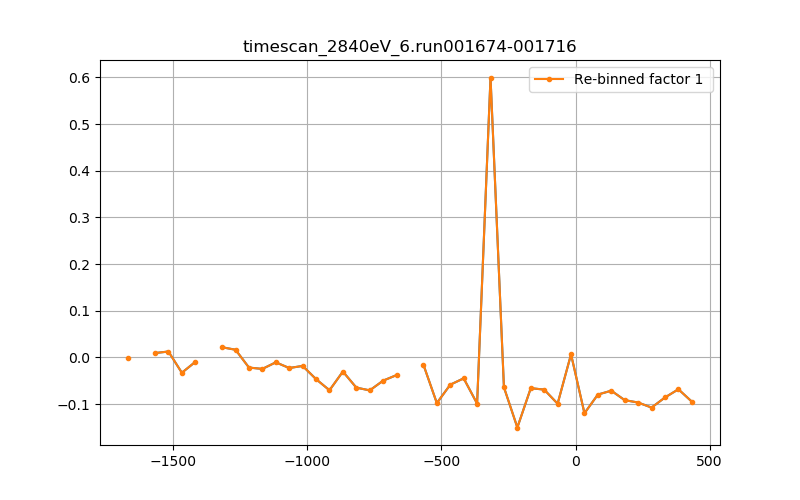

In [31]:
plt.figure(figsize = (8,5))
plt.title (scan_name + scan_range)
plt.plot (BinsCentre,Signal)
#for i in range(len(BinsCentre)):
#    xe = BinsCentre[i]
#    ye = SigSS[i]
#    plt.plot([xe] * ShotsPerBin[i], ye, 'r.', ms=.5, alpha=0.8)
plt.plot (BinsCentre, Signal, label='Re-binned factor {} '.format(reBinFac), marker='.')
#plt.plot(Delay_ps_toFit*1000, pp, label='original, {}%'.format(quantile_laser*100),marker='.')
plt.legend(loc="best")
plt.grid()
plt.show()

# Fit delay scan

In [24]:
Timezero = 155.26126
Pump_probe_tofit = pump_probe.copy()
Delay_mm_tofit = Delay_mm.copy()
Delay_ps_tofit = (Delay_mm_tofit - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

In [ ]:
# Now fit with error funciton (defined above)
index = ~(np.isnan(Delay_mm_tofit) | np.isnan(Pump_probe_tofit))

parameters_mm,extras = curve_fit(errfunc_fwhm, Delay_mm_tofit[index], Pump_probe_tofit[index], p0 = [0, 0.2, Timezero, 0.5])
t0_mm = parameters_mm[2]
width_mm = parameters_mm[3]

print("Position t0 =",np.round(t0_mm,5),"mm")
print("Width =",np.abs(np.round(width_mm,3))*1000,"um")

In [ ]:
# Now fit with error funciton (defined above)
index = ~(np.isnan(Delay_ps_tofit) | np.isnan(Pump_probe_tofit))

parameters_ps,extras = curve_fit(errfunc_fwhm, Delay_ps_tofit[index], Pump_probe_tofit[index], p0 = [0, 0.2, 0, 0.5])
t0_ps = parameters_ps[2]
width_ps = parameters_ps[3]

print("Position t0 =",np.round(t0_ps,5),"ps")
print("Width =",np.abs(np.round(width_ps,3))*1000,"fs")

In [ ]:
#... and the plot with the fit curve

plt.figure(figsize = (10,5))
plt.subplot(121)

plt.plot(Delay_mm, pump_probe, label='pump probe, {}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Delay_mm, err_low_pump_probe, err_high_pump_probe, color='lightblue')
plt.plot(Delay_mm_tofit, errfunc_fwhm(Delay_mm_tofit,*parameters_mm))
plt.grid()
plt.xlabel("delay (mm)")
plt.legend(loc="best")
plt.gca().set_title('Pump-probe vs Delay (mm)')
plt.legend(loc="best")
plt.title('t0=' + str(np.round(t0_mm, 5)) + ' mm' )


plt.subplot(122)

plt.plot(Delay_ps_tofit, pump_probe, label='pump probe, {}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Delay_ps_tofit, err_low_pump_probe, err_high_pump_probe, color='lightblue')
plt.plot(Delay_ps_tofit, errfunc_fwhm(Delay_ps_tofit,*parameters_ps))
plt.grid()
plt.xlabel("delay (ps)")
plt.legend(loc="best")
plt.gca().set_title('width = {} fs'.format(np.abs(round(width_ps,3))*1000))
plt.legend(loc="best")
#plt.title('width=' + str(np.round(width_ps_ps, 5)) + ' fs' )

print ('t0 = {} mm'.format(np.round(t0_mm, 5)))
plt.show()

In [ ]:
min_I0 = 0.01
min_fluo = 0.001
quantile_corr = 0.2

Timezero = 155.35 # position of Timezero on PP delay (in mm!)

########################################################################
json_file = DIR_json + scan_name + scan_range + ".json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 35

print ("Processing",numFiles,"files")

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

Pump_probe = []
err_Pump_probe = []

Delay_mm = []

for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists: #and i!=0:
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        (DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Delay_shot, \
         DataTrans_pump_shot, DataTrans_unpump_shot, pids_shot) = load_PumpProbe_events(filename, channel_delay)
        
        print ("Loaded {} shots".format(len(DataFluo_pump_shot)))
        
        threshold_FEL_pump = IzeroFEL_pump_shot > min_I0
        threshold_FEL_unpump = IzeroFEL_unpump_shot > min_I0
        threshold_fluo_pump = DataFluo_pump_shot > min_fluo
        threshold_fluo_unpump = DataFluo_unpump_shot > min_fluo
        
        thresholds_filter = threshold_FEL_pump & threshold_FEL_unpump & \
                            threshold_fluo_pump & threshold_fluo_unpump

        DataFluo_pump_shot = DataFluo_pump_shot[thresholds_filter]
        DataFluo_unpump_shot = DataFluo_unpump_shot[thresholds_filter]
        IzeroFEL_pump_shot = IzeroFEL_pump_shot[thresholds_filter]
        IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[thresholds_filter]
        
        print ("survived {}/{} shots".format(len(DataFluo_pump_shot), len(DataFluo_unpump_shot)))
        
        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        
        med = np.median(DataFluo_unpump_shot_norm)
        qnt_low = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 - quantile_corr/2)
        qnt_high = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 + quantile_corr/2)
        
        condition_corr_unpump_low = DataFluo_unpump_shot_norm > qnt_low
        condition_corr_unpump_high = DataFluo_unpump_shot_norm < qnt_high
        
        med = np.median(DataFluo_pump_shot_norm)
        qnt_low = np.nanquantile(DataFluo_pump_shot_norm, 0.5 - quantile_corr/2)
        qnt_high = np.nanquantile(DataFluo_pump_shot_norm, 0.5 + quantile_corr/2)

        condition_corr_pump_low = DataFluo_pump_shot_norm > qnt_low
        condition_corr_pump_high = DataFluo_pump_shot_norm < qnt_high
        
        correlation_filter = condition_corr_unpump_low & condition_corr_unpump_high & \
                             condition_corr_pump_low & condition_corr_pump_high

        DataFluo_pump_shot_norm = DataFluo_pump_shot_norm[correlation_filter]
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot_norm[correlation_filter]
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
        
        print ("survived {}/{} shots".format(len(DataFluo_pump_shot_norm), len(DataFluo_unpump_shot_norm)))
        
        df_pump = pd.DataFrame(DataFluo_pump_shot_norm)
        df_unpump = pd.DataFrame(DataFluo_unpump_shot_norm)
        df_pump_probe = pd.DataFrame(Pump_probe_shot)
        
        DataFluo_pump.append(np.nanquantile(df_pump, [0.5, 0, 1]))
        DataFluo_unpump.append(np.nanquantile(df_unpump, [0.5, 0, 1]))
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0, 1]))
        
        Delay_shot = [x for x in Delay_shot if (np.abs(x) > 0)]
        Delay_mm.append(np.mean(Delay_shot))
    
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
Pump_probe = np.asarray(Pump_probe)
                  
Delay_mm = np.asarray(Delay_mm)
Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

print ("Job done!")


In [ ]:
timelist=np.concatenate((np.arange(-1.5,-0.5-1,-1))-, np.arange(2847,2845.5-.5,-0.5),np.arange(2845,2835.25-.25,-0.25),np.arange(2835,2834.5-.5,-0.5),np.arange(2834,2831-1,-1)))

In [ ]:
def exponential_func(x,a,b,c):
    return a*np.exp(-b*x)+c

def bi_exponential_func(x,a,b,c, d, e):
    return a*np.exp(-b*x)+c+d*np.exp(-e*x)

Delay_ps = np.array(Delay_ps)
t_range = Delay_ps > 0.02 

popt,pcov = curve_fit(exponential_func, Delay_ps[t_range], -Pump_probe[t_range], p0 = (0.4, 10, 0.2))
popt2,pcov2 = curve_fit(bi_exponential_func, Delay_ps[t_range], -Pump_probe[t_range], p0 = (0.4, 0.6, 0.2, 0.4, 6))

xx= np.linspace(0, 20, 100)
yy = exponential_func(xx, *popt)
yyy= bi_exponential_func(xx, *popt2)

plt.figure()
plt.plot(Delay_ps, -Pump_probe)
plt.plot(xx, yy)
plt.plot(xx, yyy)


print(popt)
print(popt2)
